In [1]:
import utils
from batchgen import BatchGenerator
import models
import numpy as np
from os.path import join
from tensorflow import keras
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random
from tqdm import tqdm
import pickle
import cv2
from imgaug import augmenters as iaa

In [2]:
input_shape = (256, 256, 3)
batch_size = 144
k = 100
n = 20

In [3]:
# load data
dt = utils.DirectoryTree("data/Category and Attribute Prediction Benchmark/")
with open(join(dt.Anno.path, 'meta.pickle'), 'rb' ) as f:
    data = pickle.load(f)

In [4]:
args_dict = dict(
    image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
    bboxes = data['bbox_coords'],
    categories=data['cat_labels'],
    attributes=data['attr_labels'],
    eval_status=data['eval_status'],
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle = True,
    jitter = True,
    crop = True,
    mode = 'test'
)

gen = BatchGenerator(**args_dict)

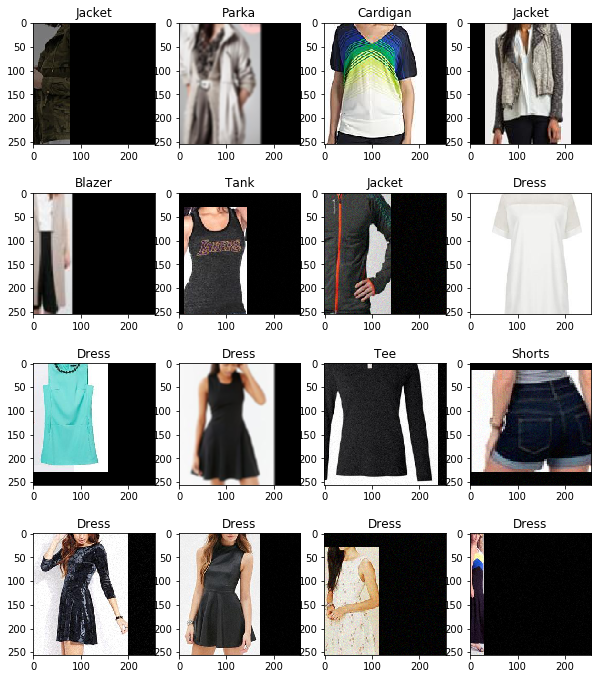

In [6]:
X, [Y_cat, Y_attr] = gen.__getitem__(k)

# plot example test images
fig, axes = plt.subplots(4, 4, figsize = (10, 12))
axes = axes.flatten()
for i, (img, cat) in enumerate(zip(X[:16], Y_cat[:16])):
    axes[i].imshow(img)
    axes[i].set_title("%s"%data['cat_index'][str(np.argmax(cat))])
plt.show()

In [7]:
# Form dataset of duplicate augmented images
X_anchor = []
Y_anchor_true = []
X_query, _ = gen.__getitem__(k)
Y_query_true = [i for i in range(batch_size)]
for i in tqdm(range(n)):
    X, _ = gen.__getitem__(k)
    X_anchor.extend(X)
    Y_anchor_true.extend([i for i in range(batch_size)])
    
X_anchor = np.array(X_anchor)
Y_anchor_true = np.array(Y_anchor_true)
print("X_anchor shape:", X_anchor.shape, "Y_anchor_true.shape:", Y_anchor_true.shape)

100%|██████████| 20/20 [00:11<00:00,  1.67it/s]

X_anchor shape: (2880, 256, 256, 3) Y_anchor_true.shape: (2880,)


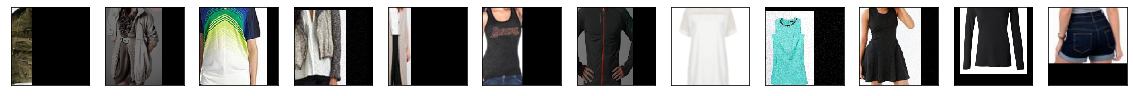

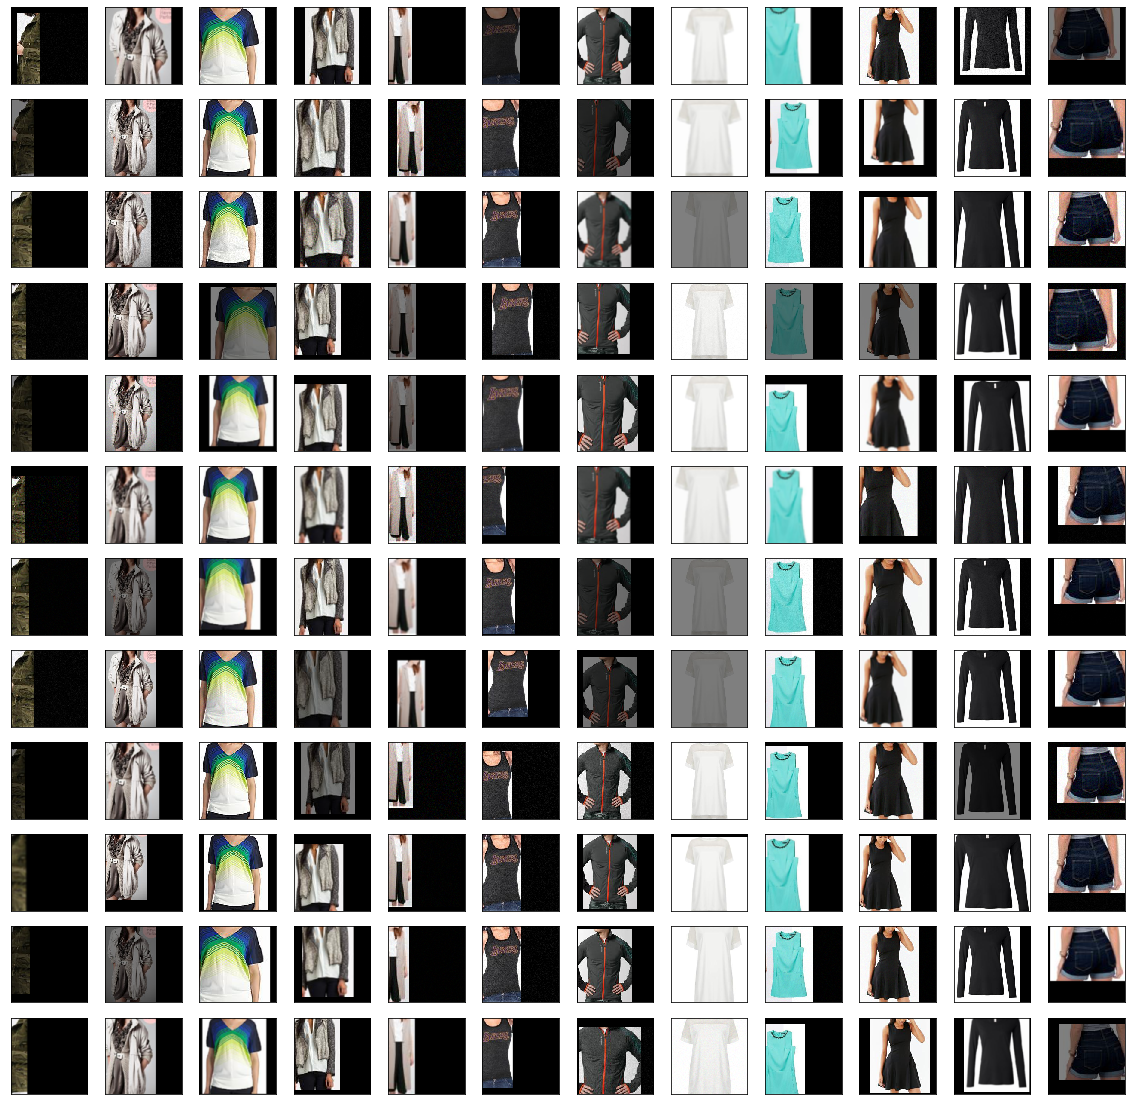

In [8]:
# plot examples from X_query and X_anchor
fig, axes = plt.subplots(1, 12, figsize = (20, 2))
axes = axes.flatten()
for i, img in enumerate(X_query[:12]):
    axes[i].imshow(img)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig, axes = plt.subplots(12, 12, figsize = (20, 20))
for col in range(12):
    for row in range(12):
        axes[row, col].imshow(X_anchor[int(row * batch_size + col)])
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.show()

In [10]:
model = keras.models.load_model("deploy/mobil-v2-pre-crop.hdf5")

In [21]:
x, y = gen.__getitem__(k)
model.evaluate(x.astype(np.float32), y, verbose = 1)

144/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.010723254332939783,
 0.007821246,
 0.0026792763,
 0.7083333,
 0.77862597,
 0.108843535,
 0.52747256]

In [11]:
Y_query_pred = model.predict(X_query.astype(np.float32), verbose = 1)
Y_anchor_pred = model.predict(X_anchor.astype(np.float32), verbose = 1)

144/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [12]:
Y_anchor_pred_cats, Y_anchor_pred_attrs = Y_anchor_pred
Y_query_pred_cats, Y_query_pred_attrs = Y_query_pred

In [13]:
cos = lambda vA, vB : np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB))) 

144it [00:31,  4.60it/s]


Mean accuracy for retrieving 20 augmented versions of 100 items: 0.8104


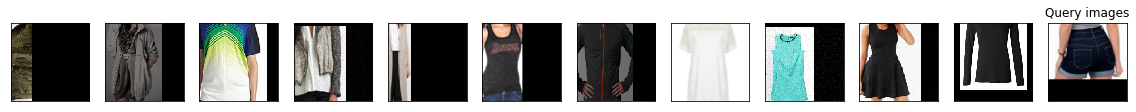

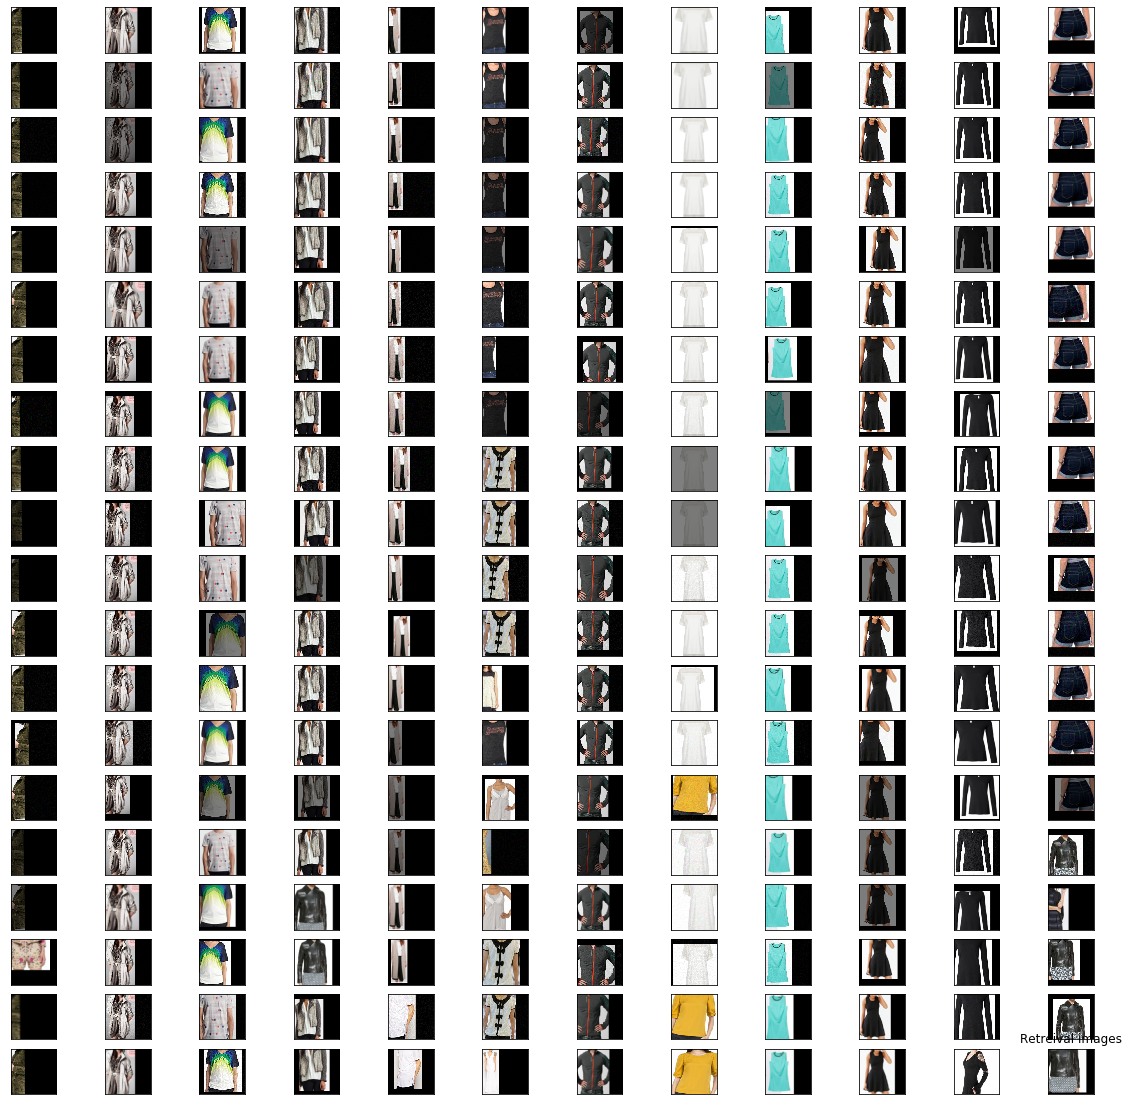

In [14]:
num_cols = 12
fig, axes = plt.subplots(1, num_cols, figsize = (20, 2))
plt.title("Query images")
axes = axes.flatten()
for i, img in enumerate(X_query[:12]):
    axes[i].imshow(img)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig, axes = plt.subplots(n, num_cols, figsize = (20, 20))
plt.title("Retreival images")
results = []
for col, (query_true, query_pred_attr) in tqdm(enumerate(zip(Y_query_true, Y_query_pred_attrs))):
    dist = [cos(query_pred_attr, anchor_pred_attr) for anchor_pred_attr in Y_anchor_pred_attrs]
    idx = np.argsort(dist, axis = 0)[::-1]
    temp = Y_anchor_true[idx][:n]
    temp_imgs = X_anchor[idx][:n]
    acc = sum(temp == query_true) / len(temp)
    results.append(acc)
    if num_cols > col:
        for row, img in enumerate(temp_imgs):
            axes[row, col].imshow(img)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])

print("Mean accuracy for retrieving %i augmented versions of %i items: %.4f"%(n, batch_size, np.mean(results)))
plt.show()